# Mini-project n° 1 - Who painted this picture?

 Le but de ce premier mini-projet est de construire et d'entraîner un réseau dans l'optique de répondre au
 challenge artchallenge.ru– "Qui a peint ce tableau ?".

 Pour cela, nous nous reférerons au jeu de données "Art Challenge" - https://plmlab.math.cnrs.fr/chevallier-teaching/datasets/art-challenge
 conteneant :
- Un fichier `artists.csv` contenant la liste des artistes ainsi que leur année de naissance et de mort, une mini biographie, leur style de peinture de prédilection, le nombre d’œuvres étudiées dans ce dataset, et un lien vers leur page wikipédia.
- Un dossier `images_lq` contenant un jeu de données de tableaux en basse qualité, nommés par auteurs.
- Un dossier `images_hq` contenant le même jeu de données de tableau mais en haute qualité.
 

In [ ]:
import PIL
from PIL import Image
import os, sys

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import optuna
from optuna.trial import TrialState

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms, models
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from collections import Counter

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

## Loading datas

In [ ]:
data_path = "./art-challenge/"
if not os.path.isdir(data_path) or not os.listdir(data_path):
    !git clone https://plmlab.math.cnrs.fr/chevallier-teaching/datasets/art-challenge.git
else:
    print("Data already downloaded!")

In [ ]:
artists = pd.read_csv(data_path + "artists.csv")
artists.head()

In [ ]:
artists_filtered = artists.loc[artists['paintings'] > 85, 'name']
artists_list = artists_filtered.tolist()
artists_list

## Analyse exploratoire

### Analyse descriptive des artistes et des styles

In [ ]:
print("Nombre total d'artistes :", artists['name'].nunique())
print("Nombre total de styles :", artists['genre'].nunique())

artists['paintings'].plot(kind='hist', bins=40, color='skyblue', edgecolor='black')
plt.title("Distribution des œuvres par artiste")
plt.xlabel("Nombre d'œuvres")
plt.ylabel("Nombre d'artistes")
plt.show()


En dessous, on considère seulement les artistes avec moins de 200 oeuvres.

In [ ]:
print("Nombre total d'artistes :", artists['name'].nunique())
print("Nombre total de styles :", artists['genre'].nunique())

artists['paintings'].plot(kind='hist', bins=80, color='skyblue', edgecolor='black')
plt.title("Distribution des œuvres par artiste")
plt.xlabel("Nombre d'œuvres")
plt.ylabel("Nombre d'artistes")
plt.xlim(0, 200)
plt.show()

styles = artists['genre'].str.split(',').explode()
style_counts = styles.value_counts()
style_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Nombre d'artistes par style de peinture")
plt.xlabel("Style de peinture")
plt.ylabel("Nombre d'artistes")
plt.xticks(rotation=90)
plt.show()

On voit que la majorité des artistes ont un nombre d'oeuvre compris entre 100 et 200. Nous allons zoomer sur cette zone, de sorte à ce que nous puissions mieux observer les nombres d'oeuvres par artistes.



### Nombre d'oeuvres par artistes et par genre

In [ ]:
artist_max = artists.loc[artists['paintings'].idxmax()]
print("Artiste avec le plus d'œuvres :")
print("Nom :", artist_max['name'])
print("Nombre d'œuvres :", artist_max['paintings'])
print("Genre :", artist_max['genre'])

artist_min = artists.loc[artists['paintings'].idxmin()]
print("\nArtiste avec le moins d'œuvres :")
print("Nom :", artist_min['name'])
print("Nombre d'œuvres :", artist_min['paintings'])
print("Genre :", artist_min['genre'])


On peut noter qu'un artiste  à plus de 800 oeuvres ( Vincent Van Gogh avec 877 oeuvres) et un artiste a 24 oeuvres (Jackson Pollock).

Nombre total d'oeuvres par genre :

In [ ]:
genres_expanded = artists['genre'].str.split(',').explode()
expanded_data = artists.loc[genres_expanded.index, ['paintings']].assign(genre=genres_expanded.values)
genre_paintings = expanded_data.groupby('genre')['paintings'].sum()

genre_paintings.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title("Nombre total d'œuvres par genre")
plt.xlabel("Genre de peinture")
plt.ylabel("Nombre total d'œuvres")
plt.xticks(rotation=90)
plt.show()

genre_paintings

En observant le nombre d'artiste par genre, on remarque que J. Pollock est le seul artiste dans sa catégorie, tandis que la catégorie de V. Van Gogh compte le plus d'artiste. De plus, en observant le nombre d'oeuvre par genre, on observe que le post impressionim compte beaucoup plus d'oeuvres que l'Expressionism. Maintenant que la distrbution des genre et des artistes est bien comprises, nous allons nous mener une analyse des périodes de vie des artistes.

### Analyse de la période de vie des artistes

In [ ]:
artists[['birth_year', 'death_year']] = artists['years'].str.split('-', expand=True)

artists['birth_year'] = pd.to_numeric(artists['birth_year'], errors='coerce')
artists['death_year'] = pd.to_numeric(artists['death_year'], errors='coerce')

artists['birth_year'].dropna().plot(kind='hist', bins=20, color='salmon', edgecolor='black')
plt.title("Distribution des années de naissance des artistes")
plt.xlabel("Année de naissance")
plt.ylabel("Nombre d'artistes")
plt.show()

artists['death_year'].dropna().plot(kind='hist', bins=20, color='purple', edgecolor='black')
plt.title("Distribution des années de décès des artistes")
plt.xlabel("Année de décès")
plt.ylabel("Nombre d'artistes")
plt.show()

In [ ]:
artists['life_duration'] = artists['death_year'] - artists['birth_year']
artists['life_duration'] = artists['life_duration'].dropna()

plt.figure(figsize=(10, 6))
artists['life_duration'].plot(kind='hist', bins=20, color='purple', edgecolor='black')
plt.title('Distribution de la durée de vie des artistes')
plt.xlabel('Durée de vie (en années)')
plt.ylabel('Nombre d\'artistes')
plt.show()

In [ ]:
longest_lived_artist = artists.loc[artists['life_duration'].idxmax()]
longest_lived_name = longest_lived_artist['name']
longest_lived_paintings = longest_lived_artist['paintings']
longest_lived_duration = longest_lived_artist['life_duration']

shortest_lived_artist = artists.loc[artists['life_duration'].idxmin()]
shortest_lived_name = shortest_lived_artist['name']
shortest_lived_paintings = shortest_lived_artist['paintings']
shortest_lived_duration = shortest_lived_artist['life_duration']

print(f"Artiste avec la plus grande durée de vie : {longest_lived_name} ({longest_lived_paintings} œuvres, {longest_lived_duration} ans)")
print(f"Artiste avec la durée de vie la plus courte : {shortest_lived_name} ({shortest_lived_paintings} œuvres, {shortest_lived_duration} ans)")


In [ ]:
correlation = artists['life_duration'].corr(artists['paintings'])
print(f"Corrélation entre durée de vie et nombre d’œuvres : {correlation}")

Nous observons que la majorité des artistes ont émergé à partir de 1800. 

### Nationalités des artistes

In [ ]:
nationality_counts = artists['nationality'].value_counts()
print("Nombre d'artistes par nationalité :")
print(nationality_counts)

top_nationalities = nationality_counts.head(10)
plt.figure(figsize=(10, 6))
top_nationalities.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Les 10 nationalités les plus représentées parmi les artistes")
plt.xlabel("Nationalité")
plt.ylabel("Nombre d'artistes")
plt.xticks(rotation=45)
plt.show()

most_represented_nationality = nationality_counts.idxmax()
least_represented_nationality = nationality_counts.idxmin()

print(f"Nationalité la plus représentée : {most_represented_nationality} ({nationality_counts.max()} artistes)")
print(f"Nationalité la moins représentée : {least_represented_nationality} ({nationality_counts.min()} artiste(s))")


On remarque que certains peintres ont plusieurs nationalités:
- Spanish,Greek
- French,British
- French,Jewish,Belarusian
- German,Swiss

De ce fait, une personne étant en française et anglaise, sera comptée dans une catégorie distincte, ici "French,British". Dans l'optique de corriger cela, nous avons dans la cellule suivante compté les personnes ayant des nationalités différentes, dans les catégories associées à chacune de leurs nationalités. Une personne française et anglaise sera donc compté dans la catégorie française ainsi que la catégorie anglaise.

In [ ]:
expanded_nationalities = artists['nationality'].str.split(',').explode()
nationality_counts = expanded_nationalities.value_counts()

print("Nombre d'artistes par nationalité :")
print(nationality_counts)

top_nationalities = nationality_counts.head(10)
plt.figure(figsize=(10, 6))
top_nationalities.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Les 10 nationalités les plus représentées parmi les artistes")
plt.xlabel("Nationalité")
plt.ylabel("Nombre d'artistes")
plt.xticks(rotation=45)
plt.show()

most_represented_nationality = nationality_counts.idxmax()
least_represented_count = nationality_counts.min()
least_represented_nationalities = nationality_counts[nationality_counts == least_represented_count].index.tolist()


print(f"Nationalité la plus représentée : {most_represented_nationality} ({nationality_counts.max()} artistes)")
print(f"Nationalité les moins représentées : {least_represented_nationalities} ({nationality_counts.min()} artiste(s))")


In [ ]:
country_paintings = artists.groupby('nationality')['paintings'].sum().sort_values(ascending=False)

print("Nombre d'œuvres par pays :")
print(country_paintings)

top_countries = country_paintings.head(10)
plt.figure(figsize=(10, 6))
top_countries.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Les 10 pays avec le plus d'œuvres d'art")
plt.xlabel("Pays")
plt.ylabel("Nombre d'œuvres")
plt.xticks(rotation=45)
plt.show()

most_paintings_country = country_paintings.idxmax()
least_paintings_country = country_paintings.idxmin()

print(f"Pays avec le plus d'œuvres : {most_paintings_country} ({country_paintings.max()} œuvres)")
print(f"Pays avec le moins d'œuvres : {least_paintings_country} ({country_paintings.min()} œuvre(s))")

Nous observons que la majorité des artistes sont français ou italien, tandis que les artistes les moins nombeux sont orginaires de Belgique, d'Autriche, ...
En outre, nous observons que la France est le pays contenant le plus d'oeuvres, suivi de l'Allemagne. L'Italie arrive en 4ème position, alors qu'elle compte deux fois plus d'artistes que l'Allemagne (4 artistes). Cela nous montre qu'un nombre plus élevé d'artiste dans un pays n'implique pas forcément un plus grand nombre d'oeuvres produites par ces artistes.

## Global params

In [ ]:
BATCH_SIZE = 32
EPOCHS = 3
CHANNELS = 3

IMAGE_HQ_SIZE = 224
IMAGE_LQ_SIZE = 64
MEAN_HQ = [0.485, 0.456, 0.406]
STD_HQ = [0.229, 0.224, 0.225]
TRANSFORM_HQ = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),  # Interpolate
    #transforms.Pad((32, 32, 32, 32)),  # Padding
    transforms.CenterCrop(224),  # Center
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN_HQ, std=STD_HQ)
])

def load_image_as_rgb_matrices(image_name):    
    img = Image.open(images_lq_path + image_name)
    img = img.resize((IMAGE_LQ_SIZE, IMAGE_LQ_SIZE))  
    img = img.convert('RGB')
    return np.array(img)

## Creating LQ images loaders

Dans cette partie, nous allons nous intéréesser au dossier `images_lq` contenant toutes les peintures, classées par artistes, en basse résolution.

In [ ]:
images_lq_path = data_path + "images_lq/"
images_filename = os.listdir(images_lq_path)

list_name = []

for filename in images_filename:
    parts = filename.split('_')
    if len(parts) > 3:
        name_surname = f"{parts[0]} {parts[1]} {parts[2]}"
    elif len(parts) == 3:
        name_surname = f"{parts[0]} {parts[1]}"
    elif len(parts) == 2:  # "Name_xxx" format
        name_surname = parts[0]  # Only Name
    list_name.append(name_surname)

In [ ]:
if len(images_filename) == len(list_name):
    total_lq_df = pd.DataFrame({
        'filename': images_filename,
        'artist': list_name,
    })
    print("DataFrame created successfully!")
else:
    print("Error: The lists have different lengths.")

### Dataloaders avec tous les artistes

In [ ]:
IMAGE_LQ_SIZE = 64
DATASET_LQ_SIZE = len(images_filename)
CHANNELS = 3

x = np.zeros((DATASET_LQ_SIZE, IMAGE_LQ_SIZE, IMAGE_LQ_SIZE, CHANNELS))
for i in range(DATASET_LQ_SIZE):
    x[i] = load_image_as_rgb_matrices(images_filename[i])

In [ ]:
classes = np.array(list(set(total_lq_df['artist'])))
classes_as_int = np.array([np.where(classes == artist)[0][0] for artist in total_lq_df['artist']])

x_train, x_test_val, y_train, y_test_val = train_test_split(
    np.transpose(x, (0, 3, 1, 2)),  classes_as_int, test_size=0.2, random_state=42
)

x_test, x_val, y_test, y_val = train_test_split(
    x_test_val, y_test_val, test_size=0.5, random_state=42
)

# Normalize images
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset_lq = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset_lq = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset_lq = TensorDataset(x_test_tensor, y_test_tensor)

train_loader_lq = DataLoader(train_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_lq = DataLoader(val_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_lq = DataLoader(test_dataset_lq, batch_size=1, shuffle=False)

print(f"Train dataset size: {len(train_dataset_lq)}")
print(f"Validation dataset size: {len(val_dataset_lq)}")
print(f"Test dataset size: {len(test_dataset_lq)}")

### Dataloaders avec les artistes ayant plus de 85 oeuvres

In [ ]:
artist_counts_lq = Counter(total_lq_df['artist'])

print("Nombre d'artistes :", len(artist_counts_lq))

print("\nNombre d'oeuvres pour chaque artiste du dataset LQ :")
for artist, count in artist_counts_lq.items():
    print(f"{artist}: {count} oeuvres")

On remarque qu'un certain nombre d'artistes ont réalisé peu d'oeuvres. Dans la partie suivante, on décide de supprimer du dataframe les artistes avec moins de 85 oeuvres réaliser pour éviter qu'ils aient un impact négatif sur l'entrainement.

In [ ]:
artist_counts_lq = Counter(total_lq_df['artist'])

artists_with_more_than_85_lq = {
    artist: count for artist, count in artist_counts_lq.items() if count > 85
}

artists_list_with_more_than_85_lq = list(artists_with_more_than_85_lq.keys())

print("Nombre d'artistes avec plus de 85 oeuvres :", len(artists_with_more_than_85_lq))

print("\nArtistes avec plus de 85 oeuvres dans les images LQ :")
for artist, count in artists_with_more_than_85_lq.items():
    print(f"{artist}: {count} oeuvres")

In [ ]:
total_lq_filtered = total_lq_df[total_lq_df['artist'].isin(artists_list_with_more_than_85_lq)].copy()

images_filename_filtered = total_lq_filtered['filename'].tolist()

DATASET_LQ_SIZE = len(images_filename_filtered)
print(f"Nombre total d'images après filtrage : {DATASET_LQ_SIZE}")

In [ ]:
x_filtered = np.zeros((DATASET_LQ_SIZE, IMAGE_LQ_SIZE, IMAGE_LQ_SIZE, CHANNELS))

for i, filename in enumerate(images_filename_filtered):
    x_filtered[i] = load_image_as_rgb_matrices(filename)
    
classes_filtered = np.array(list(set(total_lq_filtered['artist'])))
classes_as_int_filtered = np.array([
    np.where(classes_filtered == artist)[0][0] for artist in total_lq_filtered['artist']
])

x_train_filtered, x_test_val_filtered, y_train_filtered, y_test_val_filtered = train_test_split(
    np.transpose(x_filtered, (0, 3, 1, 2)),  
    classes_as_int_filtered, 
    test_size=0.2, 
    random_state=42
)

x_test_filtered, x_val_filtered, y_test_filtered, y_val_filtered = train_test_split(
    x_test_val_filtered, 
    y_test_val_filtered, 
    test_size=0.5, 
    random_state=42
)

x_train_filtered, x_val_filtered, x_test_filtered = x_train_filtered / 255.0, x_val_filtered / 255.0, x_test_filtered / 255.0

x_train_tensor_filtered = torch.tensor(x_train_filtered, dtype=torch.float32)
y_train_tensor_filtered = torch.tensor(y_train_filtered, dtype=torch.long)

x_val_tensor_filtered = torch.tensor(x_val_filtered, dtype=torch.float32)
y_val_tensor_filtered = torch.tensor(y_val_filtered, dtype=torch.long)

x_test_tensor_filtered = torch.tensor(x_test_filtered, dtype=torch.float32)
y_test_tensor_filtered = torch.tensor(y_test_filtered, dtype=torch.long)

train_dataset_lq_filtered = TensorDataset(x_train_tensor_filtered, y_train_tensor_filtered)
val_dataset_lq_filtered = TensorDataset(x_val_tensor_filtered, y_val_tensor_filtered)
test_dataset_lq_filtered = TensorDataset(x_test_tensor_filtered, y_test_tensor_filtered)

train_loader_lq_filtered = DataLoader(train_dataset_lq_filtered, batch_size=BATCH_SIZE, shuffle=True)
val_loader_lq_filtered = DataLoader(val_dataset_lq_filtered, batch_size=BATCH_SIZE, shuffle=True)
test_loader_lq_filtered = DataLoader(test_dataset_lq_filtered, batch_size=1, shuffle=False)

print(f"Train dataset size: {len(train_dataset_lq_filtered)}")
print(f"Validation dataset size: {len(val_dataset_lq_filtered)}")
print(f"Test dataset size: {len(test_dataset_lq_filtered)}")

### Plots de quelques oeuvres

In [ ]:
number_of_plots = 3
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(number_of_plots * 2, 2))

for i in range(number_of_plots):
    axes[i].imshow(x_filtered[i*100]/255.0)
    axes[i].axis('off')
    axes[i].set_title(f"{list_name[i*100]}")
    
plt.tight_layout()
plt.show()

## Creating HQ images loaders

In [ ]:
gc = "./art-challenge/images_hq"
dataset_hq = datasets.ImageFolder(root=gc, transform=TRANSFORM_HQ)
DATASET_HQ_SIZE = len(dataset_hq)
CLASS_TO_IDX_HQ = dataset_hq.class_to_idx
IDX_TO_CLASS_HQ = {idx: name for name, idx in CLASS_TO_IDX_HQ.items()}

In [ ]:
CLASS_TO_IDX_HQ = {key.replace('_', ' '): value for key, value in CLASS_TO_IDX_HQ.items()}

### Dataloaders avec tous les artistes

In [ ]:
train_size = int(0.8 * DATASET_HQ_SIZE)
val_size = int(0.1 * DATASET_HQ_SIZE)
test_size = DATASET_HQ_SIZE - train_size - val_size

train_dataset_hq, val_dataset_hq, test_dataset_hq = random_split(dataset_hq, [train_size, val_size, test_size])

train_loader_hq = DataLoader(train_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_hq = DataLoader(val_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_hq = DataLoader(test_dataset_hq, batch_size=1, shuffle=False)

print(f"Train dataset size: {len(train_dataset_hq)}")
print(f"Validation dataset size: {len(val_dataset_hq)}")
print(f"Test dataset size: {len(test_dataset_hq)}")

On remarque une différence du nombre d'oeuvres entre les dataloaders HQ et LQ.

In [ ]:
list_of_artists_hq = list(CLASS_TO_IDX_HQ.keys())

print("Nombre d'artistes :", len(list_of_artists_hq))

print("\nListe des artistes dans le dataset HQ:")
for artist in list_of_artists_hq:
    print(artist)

Le nombre d'artistes est identiques entre LQ et HQ. La différence en nombre d'oeuvres ne vient donc pas de là. Nous allons nous interessé au nombre d'oeuvres par artistes.

In [ ]:
print("Nombre d'œuvres pour chaque artiste dans le dataset HQ :")
for artist in list_of_artists_hq:
    if artist in artists['name'].values:
        num_paintings = artists.loc[artists['name'] == artist, 'paintings'].values[0]
        print(f"{artist}: {num_paintings} œuvres")
    else:
        print(f"{artist}: Nombre d'œuvres inconnu")

In [ ]:
print("Artiste(s) n'ayant pas le même nombre d'oeuvres LQ et HQ :")
for i in range(len(list_of_artists_hq)):
    count_hq = artists.loc[artists['name'] == list_of_artists_hq[i], 'paintings'].values[0]
    count_lq = artist_counts_lq.get(list_of_artists_hq[i])
    if (count_hq - count_lq !=0):
        print(list_of_artists_hq[i],": Image LQ =",count_lq,",Image HQ =", count_hq)

### Dataloaders avec les artistes ayant plus de 85 oeuvres

In [ ]:
## Long runtime ...
CLASS_TO_IDX_HQ = dataset_hq.class_to_idx
artist_counts = Counter()
for _, label in dataset_hq:
    artist = IDX_TO_CLASS_HQ[label]
    artist_counts[artist] += 1

artists_with_more_than_85_hq = {artist: count for artist, count in artist_counts.items() if count > 85}
print("Artistes avec plus de 85 occurrences :")
for artist, count in artists_with_more_than_85_hq.items():
    print(f"{artist}: {count} occurrences")

hq_class_to_new_idx = {artist: idx for idx, artist in enumerate(artists_with_more_than_85_hq)}
hq_idx_to_class = {idx: artist for artist, idx in hq_class_to_new_idx.items()}

hq_indices = [CLASS_TO_IDX_HQ[artist] for artist in artists_with_more_than_85_hq if artist in CLASS_TO_IDX_HQ]

filtered_hq_dataset = [data for data in dataset_hq if data[1] in hq_indices]

filtered_hq_dataset = [(data[0], hq_class_to_new_idx[IDX_TO_CLASS_HQ[data[1]]]) for data in filtered_hq_dataset]

train_size = int(0.8 * len(filtered_hq_dataset))
val_size = int(0.1 * len(filtered_hq_dataset))
test_size = len(filtered_hq_dataset) - train_size - val_size

train_dataset_hq_filtered, val_dataset_hq_filtered, test_dataset_hq_filtered = random_split(
    filtered_hq_dataset, [train_size, val_size, test_size]
)

train_loader_hq_filtered = DataLoader(train_dataset_hq_filtered, batch_size=BATCH_SIZE, shuffle=True)
val_loader_hq_filtered = DataLoader(val_dataset_hq_filtered, batch_size=BATCH_SIZE, shuffle=True)
test_loader_hq_filtered = DataLoader(test_dataset_hq_filtered, batch_size=1, shuffle=False)

print(f"Train dataset size: {len(train_dataset_hq_filtered)}")
print(f"Validation dataset size: {len(val_dataset_hq_filtered)}")
print(f"Test dataset size: {len(test_dataset_hq_filtered)}")

## Training et optimisation

### Fonctions `train` et `test`

In [ ]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs=EPOCHS, save_model=False, model_path="cnn_weights.pth"):
    # Training of the model
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        total_train_samples = 0
        correct_train = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            
            # FB
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # BW
            loss.backward()
            optimizer.step()
            
            # Do not need to apply softmax manually -> this order will be the same
            _, preds = torch.max(outputs, 1)
            
            correct_train += (preds == labels).sum().item()

            train_loss += loss.item()
            total_train_samples += images.size(0)
        
        train_loss = train_loss / total_train_samples
        train_accuracy = correct_train / total_train_samples

        # Validation
        model.eval()
        val_loss = 0.0
        total_val_samples = 0
        correct_val = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                total_val_samples += images.size(0)
                
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
        
        val_loss = val_loss / total_val_samples
        val_accuracy = correct_val / total_val_samples
        
        # Train accuracy could be used to check if the network learns something
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if save_model:
        torch.save(model.state_dict(), model_path)

In [ ]:
def test(test_loader, model_path="cnn_weights.pth"):
    model = get_model(weights=None)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model = model.to(DEVICE)

    # Validation
    model.eval()
    test_loss = 0.0
    total_test_samples = 0
    correct_test = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
                
            outputs = model(images)
            loss = criterion(outputs, labels)
                
            test_loss += loss.item()
            total_test_samples += images.size(0)
                
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
        
        test_loss = test_loss / total_test_samples
        test_accuracy = correct_test / total_test_samples

        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return test_loss, test_accuracy

### ResNet18

file:///C:/Users/acer/Downloads/10.1007s10916-019-1475-2.pdf

page 8

Le premier modèle sur lequel nous allons nous pencher est ResNet18. 
Le modèle ResNet18 est une version simplifiée du réseau résiduel ResNet, l'une des architectures de réseaux de neurones convolutionnels les plus populaires.
Le réseau ResNet 18 est composé de 18 couches ( 17 couches convolutionnelles, une couche FC + softmax) organisées de la manière suivante : 
Tout d'abord, il y'a une première couche convolutive :
- il y'a 64 filtres de taille 7x7 se déplaçant avec un stride=2. Il y a également un padding=3 appliqué sur l'image initiale.

Ensuite, il y a 8 blocs résiduels, chacun composé de 2 couches de convolutions. Ces blocs résiduels ont un rôle central dans les réseaux ResNet car ils permettent de faire face au problème de Vanishing Gradient. L'idée de ces blocs est d'ajouter des connexions résiduelles ( des "skips connections") entre l'entrée et la sortie du bloc. (couche de convolution de noyau 1x1 pour ajustement dimensionnel si la dimension de l'entrée et de la sortie n'est pas la même )
Chacun des blocs est composée de deux couches convolutives et d'une connexion résiduelles(permettant ainsi de péserver l'information en entrée).
Les couches convolutionnelles des blocs appliquent des un nombre variable de filtres de taille 3x3, grandissant au fur et à mesure. En effet, les deux premières couches convolutionnelles contiennent 64 filtres, les deux suivantes 128 filtres, les deux suivantes 256 et les deux dernières 512. Après chacune de ces couches convolutionnelles s'ajoute une Batch Normalization, avant l'activation ReLU. Cette normalisation permet de rendre les sorties des couches plus stables avant l'application de la fonction d'activation reLu.

Enfin, il y a une couche de Global Average Pooling suivie d'une couche fully-connected puis d'une couche softmax de manière à faire la classification.



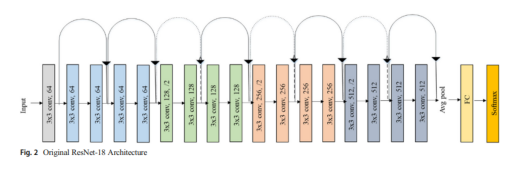

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Spécifiez le chemin de votre image
img_path = 'Capture d’écran_ResNet-18.png'  # Remplacez par le nom de votre fichier

# Charger l'image
img = mpimg.imread(img_path)

# Afficher l'image
plt.imshow(img)
plt.axis('off')  # Désactive les axes
plt.show()

In [ ]:
NUM_CLASSES = len(artists_with_more_than_85_hq)
DROPOUT_RATE = 0.4

def get_model(name='resnet18', weights='IMAGENET1K_V1', verbose=False):
    model = getattr(models, name)(weights=weights)
    model.fc = nn.Sequential(
        nn.Dropout(p=DROPOUT_RATE),                  
        nn.Linear(model.fc.in_features, NUM_CLASSES)
    ) 

    if verbose:
        trainable_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable_params}')
        
    return model

### Optuna

In [ ]:
# Here we use Optuna to optimize the best hyper-params
# Long time execution...
# See https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py
def objective(trial):
    # Define the model
    model = get_model()
    model = model.to(DEVICE)

    # The different parameters we're trying to improve
    fc_lr = trial.suggest_float("fc_lr", 1e-4, 1e-2, log=True)  
    base_lr = trial.suggest_float("base_lr", 1e-6, 1e-4, log=True)

    base_params = [p for name, p in model.named_parameters() if "fc" not in name]    
    # Init optimizer
    optimizer = optim.Adam([
        {'params': model.fc.parameters(), 'lr': fc_lr},      # LR for fully connected layer
        {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
    ])

    # Loss
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(EPOCHS):
        # Training
        model.train()
        for images, labels in tqdm(train_loader_hq_filtered):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
                
            optimizer.zero_grad()
                
            # FB
            outputs = model(images)
            loss = criterion(outputs, labels)
                
            # BW
            loss.backward()
            optimizer.step()
            
        # Validation
        model.eval()
        total_val_samples = 0
        correct_val = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader_hq_filtered):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                    
                outputs = model(images)
                loss = criterion(outputs, labels)
                    
                total_val_samples += images.size(0)
                    
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
            
        val_accuracy = correct_val / total_val_samples
        trial.report(val_accuracy, epoch)
    
    # Handle pruning based on the intermediate value.
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return val_accuracy

### Optimisation sur ResNet18 avec Optuna

In [ ]:
# Default sampler used: https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

### Training avec les paramètres optimisés

In [ ]:
# Define the model
model1 = get_model(weights=None)
model1 = model1.to(DEVICE)

# Valeurs trouvées précédemment
fc_lr = 6.47e-4  
base_lr = 8.587e-5

base_params = [p for name, p in model1.named_parameters() if "fc" not in name] 

# Init optimizer
optimizer = optim.Adam([
    {'params': model1.fc.parameters(), 'lr': fc_lr},      # LR for fully connected layer
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')

train(model1, criterion, optimizer, train_loader_hq_filtered, val_loader_hq_filtered, epochs=10, save_model=True)

In [ ]:
loss, acc = test(test_loader_hq)

On constate une convergence des accuracy d'entrainement et de validation dès la 5e itération. Le modèle a toutefois tendance à overfitter, avec une `train accuracy` de 0.99 mais une `val accuracy` = 0.79 et une `test accuracy` = 0.76.

### EfficientNet

EfficientNet existe en plusieurs versions:
- EfficientNet_Bx (x $ \in [0:7]$) : Précision, durée de calcul, profondeur de réseau et résolution augmentent avec x
- EfficientNet_V2_t (t $ \in $ [s,l,m]) : Version améliorée de EfficientNet_Bx, existe en 3 versions : Small, Medium et Large

In [ ]:
# La fonction get_model est redéfinie car EfficientNet ne possède pas de fully connected layer (.fc pour ResNet)
def get_model_v2(name='efficientnet_v2_s', weights='IMAGENET1K_V1', verbose=False):
    model = getattr(models, name)(weights=weights)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

    if verbose:
        trainable_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable_params}')
        
    return model

Nous allons nous pencher sur les variantes small et medium de la famille de réseaux convolutifs EfficientNet-v2.

#### Small

https://www.researchgate.net/publication/373782480_Identification_of_Individual_Hanwoo_Cattle_by_Muzzle_Pattern_Images_through_Deep_Learning

https://www.researchgate.net/figure/MBConv-and-fused-MBConv-blocks-extensively-utilized-by-EfficientNetV2-CNNs-Fused-MBConv_fig3_360226441

L'architecture de EfficientNet-V2-s est composée des différentes parties suivantes : 
Tout d'abord, l'image passe par une couche convolutionnelle, comportant des filtres 3x3 se déplaçant d'un stride=2. 
Ensuite, on retrouve les blocs Fused MBConv et MBConv. Un bloc Fused MBConv est composé d'une couche convolutionnelle (appliquant des filtres 3x3),suivie d'un Squeeze and Excitation (SE) suivie d'une couche convolutionnelle (filtre 1x1). De plus, on note la présence d'une connexion résiduelle (skip connexion).
Le SE permet d'identifier les canaux pertinents et de réduire l'importance des canaux moins importants et donc d'optimiser l'apprentissage en donnant plus de poids aux canaux importants.
Les blocs Fused-MBConv sont utilisés au début car ils sont optimisés pour se concentrer sur des détails simples. 
Il y aura 2 blocs Fused-MBConv1 puis 2 blocs Fused-MBConv4 et 4 blocs Fused-MBConv4. 

Le bloc MBConv est composée d'une couche convolutonnelle (filtre 1x1) suivie d'une convolution Depthwise (3x3)  puis d'un Squeeze and Excitation et d'une convolution 1x1. On note également la présence d'une skip connexion.
Les blocs MBConv sont utilisés comme des couches profondes car ils sont plus adaptés pour apprendre des relations complexes.
On retrouvera après les blocs Fused MBConv, 6 blocs MBCONv4, puis 9 blocs MBCONv6 et 15 blocs MBCONv6.

Enfin, les couches finales du réseaux sont une convolution 1x1 suivie d'un Global Average Pooling puis d'une couche dense. 

Sur la figure ci-dessous, le nombre à droite des rectangles corresponds au nombre de couches et les nombres en dessous de chacun des rectangles correspondent au stride (à gauche) et au canaux (à droite).


Le  "0.25" dans "SE 0.25", corresponds au ratio de réduction des canaux (les canaux passent, lors de l'étape d'excitation, dans une couche dense et vont voir leur nombre passer à 0.25 de la taille initiale).

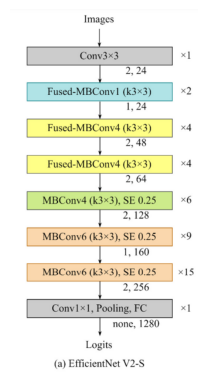

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Spécifiez le chemin de votre image
img_path = 'Capture d’écran_efficientNetV2-S.png'  # Remplacez par le nom du fichier

# Charger l'image
img = mpimg.imread(img_path)

# Afficher l'image
plt.imshow(img)
plt.axis('off')  # Désactive les axes
plt.show()

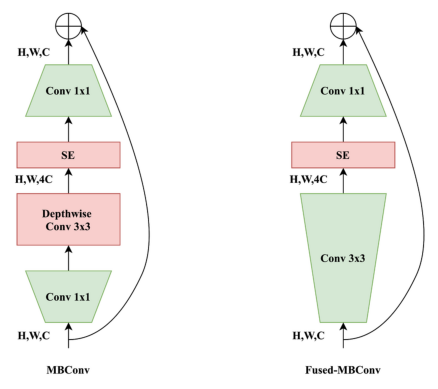

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Spécifiez le chemin de votre image
img_path = 'MBConv-and-fused-MBConv_EfficientNetv2.png'  # Remplacez par le nom du fichier

# Charger l'image
img = mpimg.imread(img_path)

# Afficher l'image
plt.imshow(img)
plt.axis('off')  # Désactive les axes
plt.show()

In [ ]:
model = get_model_v2(name='efficientnet_v2_s')
model = model.to(DEVICE)

fc_lr = 6.47e-4  
base_lr = 8.587e-5
# Assure-toi que NUM_CLASSES est mis à jour avec les artistes filtrés
NUM_CLASSES = len(artists_with_more_than_85)  # Nombre de classes après filtrage


base_params = [p for name, p in model.named_parameters() if "classifier.1" not in name]    
# Init optimizer
optimizer = optim.Adam([
    {'params': model.classifier[1].parameters(), 'lr': fc_lr},      # LR for fully connected layer
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=10, save_model=True)

In [ ]:
loss, acc = test(test_loader_hq)

In [ ]:
# Pour libérer la VRAM après entrainement du modèle
torch.cuda.empty_cache()

Comme pour ResNet18, EfficientNet Small a tendance à overffiter (`train accuracy` = 0.99 et `val accuracy` = 0.83). La `test accuracy` est légerement meilleure (0.81 vs. 0.76). La durée d'entrainement est toutefois ~4x plus longue.

#### Medium

L'architecture de EfficientNet-v2-m est assez similaire à celle de EfficientNet-v2-s. On notera juste une utilisation de plus de blocs Fused MBConv et MBConv.

In [ ]:
model = get_model(name='efficientnet_v2_m')
model = model.to(DEVICE)

fc_lr = 6.47e-4  
base_lr = 8.587e-5
# Assure-toi que NUM_CLASSES est mis à jour avec les artistes filtrés
NUM_CLASSES = len(artists_with_more_than_85)  # Nombre de classes après filtrage


base_params = [p for name, p in model.named_parameters() if "classifier.1" not in name]    
# Init optimizer
optimizer = optim.Adam([
    {'params': model.classifier[1].parameters(), 'lr': fc_lr},      # LR for fully connected layer
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=10, save_model=True)

In [ ]:
loss, acc = test(test_loader_hq)

In [ ]:
# Pour libérer la VRAM après entrainement du modèle
torch.cuda.empty_cache()

#### Large

Le modèle est large est trop grand pour s'éxécuter ou alors s'éxécute dans un temps déraisonable (dépend de la VRAM et RAM disponible). Il est implémenté dans les cellules suivante mais n'a pas été testé pour l'instant.

In [ ]:
model = get_model(name='efficientnet_v2_l')
model = model.to(DEVICE)

fc_lr = 6.47e-4  
base_lr = 8.587e-5
# Assure-toi que NUM_CLASSES est mis à jour avec les artistes filtrés
NUM_CLASSES = len(artists_with_more_than_85)  # Nombre de classes après filtrage


base_params = [p for name, p in model.named_parameters() if "classifier.1" not in name]    
# Init optimizer
optimizer = optim.Adam([
    {'params': model.classifier[1].parameters(), 'lr': fc_lr},      # LR for fully connected layer
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=5, save_model=True)

In [ ]:
loss, acc = test(test_loader_hq)

In [ ]:
# Pour libérer la VRAM après entrainement du modèle
torch.cuda.empty_cache()

### Inception V3

Source : https://medium.com/@AnasBrital98/inception-v3-cnn-architecture-explained-691cfb7bba08

Le modèle Inception v3 repose sur le concept de blocs Inception, permettant d'extraire des caractéristiques à différentes échelles.
L'architecture de Inception-v3 se décrit comme suit:
Tout d'abord, il y a une première partie chargée de réduire la taille de l'image et d'extraire les caractéristiques basiques. Cette première partie est composée de 3 convolution successives (2 couches convolutionnelles de 32 filtres 3x3, puis une couche convolutionnelle de 64 filtres 3x3. Le stride et le padding varient), d'un max pooling (stride=2), puis deux convolutions(1 convolution avec 80 filtres 1x1, puis une convolution avec 192 filtres 3x3), puis un max pooling(stride=2).
Ensuite, la sortie passe par différents blocs Inception,permettant d'extraire des caractéristiques à différentes échelles. Chacun de ces blocs utilisent plusieurs chemins parallèles de convolution et de max pooling. Un bloc d'Inception contient différents chemins : 
- Le premier chemin : convolution 1x1 suivie de deux convolutions 3x3.
- Le second chemin : convolution 1x1 suivie d'une convolution 3x3.
- Le troisième chemin : Average Pooling suivie d'une convolution 1x1.
- Le quatrième chemin : Une convolution 1x1.
L'entrée du bloc d'Inception passera donc par tous ces chemins parallèles, puis les sorties de ces chemins seront concaténées.

On retouve également des blocs de réduction chargés de réduire la dimension spatiale tout en augmentant le nombre de canaux. Les blocs de réduction utilisent tout comme les blocs Inception des chemins parallèles. Les trois chemins parallèles peuvent être les suivants : 
- Le premier chemin : Un Max Pooling 3x3.
- le deuxième chemin : Une convolution 3x3.
- le troisième chemin : Une convolution 1x1 suivie de deux convolutions 3x3.
L'entrée du bloc de réduction passera donc par tous ces chemins parallèles, puis les sorties de ces chemins seront concaténées.

On retrouve également un bloc auxiliaire, se situant entre le deuxième bloc d'Inception et le deuxième bloc de réduction.
L'architecture de ce bloc est la suivante : 
Tout d'abord, il y a un averge pooling 5x5, suivie d'une convolution 1x1. Ensuite, un flatten est appliqué de manière à avoir nos données sous forme d'un vecteur d'une dimension. On retrouve après cela deux couches FC, avec un dropout (permettant de limiter le surapprentissage) appliqué à la dernière couche dense. Enfin, la couche de sortie softmax réalise la classification.
Ce bloc auxiliaire permet d'apporter une supervisation supplémentaire lors de l'entrainement. 

Enfin, il y a l'étape de classification. Un global average pooling est appliqué à la sortie du troisième bloc d'Inception. Ensuite une couche dense et une couche de softmax(nous donnant la probabilité de chaque classe).


Il est important de noter qu'il y a différents blocs d'Inception et de blocs de réduction. De ce fait, les chemins parallèles présentés précedemment, ne sont pas les mêmes pour chacuns des blocs, nous nous sommes penchés en détails sur un seul bloc d'Inception et de Réduction de manière à bien comprendre l'architecture globale de ces blocs. En effet, comme la figure ci-dessous, représentant l'architecture de Inception v3, le montre, on retouve 3 blocs d'Inceptions et 2 blocs de Réductions.

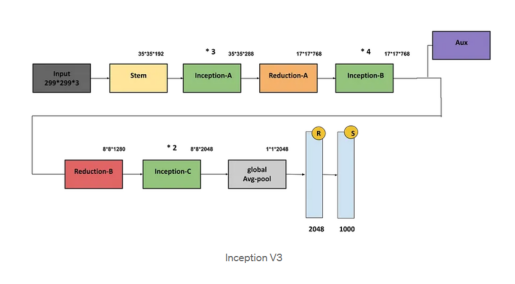

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Spécifiez le chemin de votre image
img_path = 'Capture d’écran_Inception_v3.png'  # Remplacez par le nom de votre fichier

# Charger l'image
img = mpimg.imread(img_path)

# Afficher l'image
plt.imshow(img)
plt.axis('off')  # Désactive les axes
plt.show()

Pour le modèle Inception, les images doivent être de taille minimale 299x299.

In [ ]:
TRANSFORM_HQ_IncV3 = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize all images to 299x299
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(
        mean=MEAN_HQ,  # Normalize with ImageNet means
        std=STD_HQ    # Normalize with ImageNet std deviations
    ),
])

# Charger le dataset HQ
gc = "./art-challenge/images_hq"
dataset_hq = datasets.ImageFolder(root=gc, transform=TRANSFORM_HQ_IncV3)
DATASET_HQ_SIZE = len(dataset_hq)
CLASS_TO_IDX_HQ = dataset_hq.class_to_idx
IDX_TO_CLASS_HQ = {idx: name for name, idx in CLASS_TO_IDX_HQ.items()}

# Comptage des occurrences pour chaque artiste
artist_counts = Counter()
for _, label in dataset_hq:
    artist = IDX_TO_CLASS_HQ[label]
    artist_counts[artist] += 1

# Filtrer les artistes ayant plus de 85 occurrences
artists_with_more_than_85 = {artist: count for artist, count in artist_counts.items() if count > 85}
print("Artistes avec plus de 85 occurrences :")
for artist, count in artists_with_more_than_85.items():
    print(f"{artist}: {count} occurrences")

# Réindexer les classes en fonction des artistes filtrés
hq_class_to_new_idx = {artist: idx for idx, artist in enumerate(artists_with_more_than_85)}
hq_idx_to_class = {idx: artist for artist, idx in hq_class_to_new_idx.items()}

# Filtrer les indices des artistes sélectionnés
hq_indices = [CLASS_TO_IDX_HQ[artist] for artist in artists_with_more_than_85 if artist in CLASS_TO_IDX_HQ]

# Filtrer les données du dataset HQ pour ne garder que les indices valides
filtered_hq_dataset = [data for data in dataset_hq if data[1] in hq_indices]

# Mise à jour des labels du dataset filtré pour correspondre aux nouveaux indices
filtered_hq_dataset = [(data[0], hq_class_to_new_idx[IDX_TO_CLASS_HQ[data[1]]]) for data in filtered_hq_dataset]

# Création des ensembles de données filtrés
train_size = int(0.8 * len(filtered_hq_dataset))
val_size = int(0.1 * len(filtered_hq_dataset))
test_size = len(filtered_hq_dataset) - train_size - val_size

train_dataset_hq, val_dataset_hq, test_dataset_hq = random_split(
    filtered_hq_dataset, [train_size, val_size, test_size]
)

# Chargement des ensembles de données dans les DataLoaders
train_loader_hq = DataLoader(train_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_hq = DataLoader(val_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_hq = DataLoader(test_dataset_hq, batch_size=1, shuffle=False)

# Affichage des tailles des datasets
print(f"Train dataset size: {len(train_dataset_hq)}")
print(f"Validation dataset size: {len(val_dataset_hq)}")
print(f"Test dataset size: {len(test_dataset_hq)}")

In [ ]:
#NUM_CLASSES = len(dataset_hq.classes) # Same value for lQ dataset
NUM_CLASSES = len(artists_with_more_than_85)
DROPOUT_RATE = 0.4
MODEL_PATH = "cnn_weights.pth"

def get_model(name='inception_v3', weights='IMAGENET1K_V1', verbose=False):
    model = getattr(models, name)(weights=weights)
    model.fc = nn.Sequential(
        nn.Dropout(p=DROPOUT_RATE),                  
        nn.Linear(model.fc.in_features, NUM_CLASSES)
    ) 

    if verbose:
        trainable_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable_params}')
        
    return model

In [ ]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs=EPOCHS, save_model=False, model_path=MODEL_PATH):
    # Training of the model
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        total_train_samples = 0
        correct_train = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            
            # FB
            main_logits, aux_logits = model(images)
            loss1 = criterion(main_logits, labels)
            loss2 = criterion(aux_logits, labels)
            loss = loss1 + 0.4*loss2                    #0.4 has been chosen by the author of the original Inception paper
            
            # BW
            loss.backward()
            optimizer.step()
            
            # Do not need to apply softmax manually -> this order will be the same
            _, preds = torch.max(main_logits, 1)
            correct_train += (preds == labels).sum().item()

            train_loss += loss.item()
            total_train_samples += images.size(0)
        
        train_loss = train_loss / total_train_samples
        train_accuracy = correct_train / total_train_samples

        # Validation
        model.eval()
        val_loss = 0.0
        total_val_samples = 0
        correct_val = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                total_val_samples += images.size(0)
                
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
        
        val_loss = val_loss / total_val_samples
        val_accuracy = correct_val / total_val_samples
        
        # Train accuracy could be used to check if the network learns something
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if save_model:
        torch.save(model.state_dict(), model_path)    

In [ ]:
model = get_model(name='inception_v3', weights='IMAGENET1K_V1', verbose=False)
model = model.to(DEVICE)

# The best values found previously
fc_lr = 6.47e-4  
base_lr = 8.587e-5
# Assure-toi que NUM_CLASSES est mis à jour avec les artistes filtrés
NUM_CLASSES = len(artists_with_more_than_85)  # Nombre de classes après filtrage


base_params = [p for name, p in model.named_parameters() if "fc" not in name]    
# Init optimizer
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': fc_lr},      # LR for fully connected layer
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=10, save_model=True)

In [ ]:
loss, acc = test(test_loader_hq)

### VGG

In [ ]:
#NUM_CLASSES = len(dataset_hq.classes) # Same value for lQ dataset
NUM_CLASSES = len(artists_with_more_than_85)
DROPOUT_RATE = 0.4
MODEL_PATH = "cnn_weights.pth"

def get_model(name='vgg16', weights='IMAGENET1K_V1', verbose=False):
    model = getattr(models, name)(weights=weights)
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier[0].in_features, 4096),  # Maintain VGG16's architecture
        nn.ReLU(inplace=True),
        nn.Dropout(p=DROPOUT_RATE),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=DROPOUT_RATE),
        nn.Linear(4096, NUM_CLASSES)  # Output layer with NUM_CLASSES units
    )

    if verbose:
        trainable_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable_params}')
        
    return model

#### VGG-16

Le modèle VGG 16 est une architecture de CNN, composé de plusieurs couches convolutionnelles et de plusieurs couches full-connected. 
La partie du modèles composée des couches convolutionnelles se caractérise par une alternance de couches convolutionnelles et de max pooling. 
Les couches convolutionnelles utilisent un nombre de filtres de taille 3x3, augmentant au fur à mesure que l'on avance dans le CNN. Le nombre de filtres passe de 64 à 128 puis 256 puis 512.

Comme représenté sur le schéma ci dessous, il y a une alternance de cinq "blocs de convolutions" suivie de trois FC.
Ces blocs de convolutions, chargés de l'extraction de caractéristiques, permettent de diminuer la taille de l'image tout en augmentant la taille des canaux. Ils sont chacuns composés de deux à trois couches de convolutions successives suivie d'un max pooling.

Les trois couches denses suivants ces blocs convolutionnelles, vont à partir d'un vecteur reçu des couches convolutionnelles, effectuer la classification.

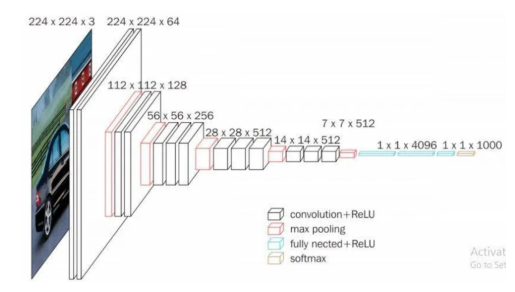

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Spécifiez le chemin de votre image
img_path = 'Capture d’écran_VGG_16.png'  # Remplacez par le nom de votre fichier

# Charger l'image
img = mpimg.imread(img_path)

# Afficher l'image
plt.imshow(img)
plt.axis('off')  # Désactive les axes
plt.show()

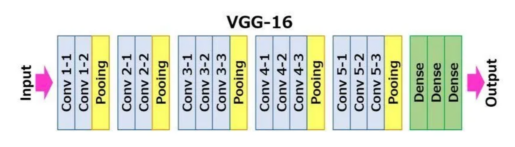

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Spécifiez le chemin de votre image
img_path = 'Capture d’écran_VGG_16_2.png'  # Remplacez par le nom de votre fichier

# Charger l'image
img = mpimg.imread(img_path)

# Afficher l'image
plt.imshow(img)
plt.axis('off')  # Désactive les axes
plt.show()

In [ ]:
# Define the model
model = get_model(name='vgg16')
model = model.to(DEVICE)

# The best values found previously
fc_lr = 6.47e-4  
base_lr = 8.587e-5
# Assure-toi que NUM_CLASSES est mis à jour avec les artistes filtrés
NUM_CLASSES = len(artists_with_more_than_85)  # Nombre de classes après filtrage

base_params = [p for name, p in model.named_parameters() if "classifier" not in name]
classifier_params = model.classifier.parameters() 
# Init optimizer
optimizer = optim.Adam([
    {'params': classifier_params, 'lr': fc_lr},          # LR for classifier layers
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=5, save_model=True)

#### VGG-19

L'architecture de VGG 19 est pratiquement similaire à celle de VGG16, à la différence que VGG 19 contient 3 couches convolutionnelles supplémentaires (contenant 512 filtres de taille 3x3).

In [ ]:
# Define the model
model = get_model(name='vgg19')
model = model.to(DEVICE)

# The best values found previously
fc_lr = 6.47e-4  
base_lr = 8.587e-5
# Assure-toi que NUM_CLASSES est mis à jour avec les artistes filtrés
NUM_CLASSES = len(artists_with_more_than_85)  # Nombre de classes après filtrage

base_params = [p for name, p in model.named_parameters() if "classifier" not in name]
classifier_params = model.classifier.parameters() 
# Init optimizer
optimizer = optim.Adam([
    {'params': classifier_params, 'lr': fc_lr},          # LR for classifier layers
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=5, save_model=True)

## Focal Loss

Comme observé durant l'analyse descriptive, les artistes n'ont pas tous le même nombre d'oeuvres. En effet, certains artistes ont une vingtaine d'oeuvres tandis que d'autres en ont plus de 800. Cela peut s'avérer être assez problématique dans le calcul de la loss, de ce fait, nous allons utiliser une focal loss. Cette loss permet de traiter les déséquilibre dans les "classes", elle est une modification de la cross entropy en ajoutant un terme de pondération. 
Cette perte permettra d'éviter que certains artistes avec beaucoup d'oeuvres contribuent trop à la loss. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Poids par classe (peut être un tensor)
        self.gamma = gamma  # Facteur de focalisation
        self.reduction = reduction  # mean, sum ou none

    def forward(self, inputs, targets):
        # Appliquer un softmax pour convertir les logits en probabilités
        probs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=inputs.size(1)).float()
        
        # Extraire les probabilités des classes cibles
        pt = (probs * targets_one_hot).sum(dim=1)
        
        # Calculer la focal loss
        focal_loss = -((1 - pt) ** self.gamma) * torch.log(pt)
        
        # Appliquer les poids de classe si fournis
        if self.alpha is not None:
            at = self.alpha.gather(0, targets)
            focal_loss *= at
        
        # Réduire la perte si nécessaire
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [ ]:
# Extraire les informations sur les artistes et leurs œuvres
artist_counts = artists['paintings'].values
total_paintings = artist_counts.sum()

# Inverser la proportion pour accorder plus de poids aux artistes avec peu d'œuvres
weights = total_paintings / (len(artist_counts) * artist_counts)
alpha = torch.tensor(weights, dtype=torch.float32)


In [ ]:
from collections import Counter
import numpy as np
import torch

# Fréquence des classes dans le dataset
class_counts = Counter(dataset_hq.targets)  # `targets` contient les labels des artistes
total_samples = sum(class_counts.values())

# Calcul des poids inversés pour chaque classe
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
class_weights = torch.tensor([class_weights[cls] for cls in sorted(class_counts.keys())], dtype=torch.float32).to(DEVICE)


In [ ]:
import torch
import torch.nn as nn

class FocalLossWithWeights(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, class_weights=None):
        super(FocalLossWithWeights, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.class_weights = class_weights  # Poids spécifiques aux classes

    def forward(self, inputs, targets):
        # Appliquer softmax pour obtenir les probabilités
        probs = torch.softmax(inputs, dim=1)
        probs = probs.gather(1, targets.view(-1, 1)).squeeze()

        # Focal Weighting
        focal_weight = (1 - probs) ** self.gamma

        # Log-loss avec les poids des classes
        if self.class_weights is not None:
            weights = self.class_weights[targets]
            loss = -self.alpha * weights * focal_weight * torch.log(probs + 1e-8)
        else:
            loss = -self.alpha * focal_weight * torch.log(probs + 1e-8) # +1e-8 pour éviter d'avoir 0

        return loss.mean()
